<a href="https://colab.research.google.com/github/JaleelSavoy/DataReports/blob/master/DeepAutoencoders_fMNIST.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Deep Autoencoders with Fashion-MNIST

The objective of this notebook is to explore the performance of an two deep autoencoders, one will encode and decode flattened images using only dense, fully-connected layers and the other will use convolutional layers. Intuitively, the hypothesis is that the deep convolutional autoencoder will have superior reconstruction performance when compared to the basic, deep autoencoder. 

The basic 11-layer deep autoencoder will train 5,228,832 parameters and the 9-layer convolutional autoencoder will train 24,937 parameters.

## Background on Fashion-MNIST
The Fashion-MNIST data set is made up of 70,000 fashion items (60,000 for training and 10,000 for testing) based on an assortment from the Zalando website, with 10 distinct classes and 7,000 images for each class. The data set was proposed as a modern replacement to the original, extremely popular MNIST data set as dataset to standardize and benchmark research results. 

## Background on standard autoencoders
Autoencoders are neural networks where the input is also the target out; autoencoders learn to map an input to some latent embeddings and then reconstruct the original input based on the latent embedding. The three main components of an autoencoder are the encoder function, the decoder function, and a loss function to tell the network how far its reconstructions are from the original input. While autoencoders perform data compression and decompression, they are not typically better than basic compression algorithms that are specific to certain formats. They are mainly used as a flexible dimensionality reduction method (it can perform nonlinear dimensionality reduction) and it can be used to denoising data. 

## Background on convolutional autoencoders
For processing image data, convolutional layers are typically added to neural networks and those networks are termed convolutional neural networks. Convolutional autoencoders are just like the previous autoencoders, but the mapping to the latent embeddings is done using convolutional layers.

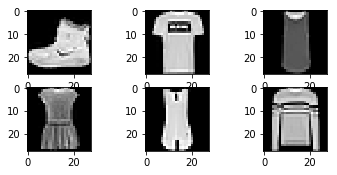

In [15]:
# import relevant packages
import numpy as np
import pandas as pd
import tensorflow as tf
import keras
from keras.models import Sequential
from keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, Flatten, Reshape, Dense, Dropout, BatchNormalization, Activation
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import cross_val_score, KFold
from sklearn.preprocessing import RobustScaler
import matplotlib.pyplot as plt


# set seed
seed = 123
np.random.seed(seed)
tf.set_random_seed(seed)

# load the housing dataset (built-in for keras)
from keras.datasets import fashion_mnist
(x_train, y_train), (x_test, y_test) = fashion_mnist.load_data()

# preview 6 images
for i in range(6):
	plt.subplot(330 + 1 + i)
	plt.imshow(x_train[i], cmap=plt.get_cmap('gray'))
plt.show()

# reshape image --> single channel
x_train, x_test = (x_train.reshape((x_train.shape[0], 28, 28, 1)),
                   x_test.reshape((x_test.shape[0], 28, 28, 1)))

# convert the target to one-hot encoded vectors
y_train, y_test = (keras.utils.to_categorical(y_train),
                   keras.utils.to_categorical(y_test))

# scale pixel intensity values to be between 0 and 1 (inclusive)
x_train, x_test = x_train/255.00, x_test/255.00

## Standard Deep Autoencoder

In [0]:
# Simple Autoencoder that uses flattened images
ae_input_data = Input(shape=(28, 28, 1))

ae_x = Flatten()(ae_input_data)

ae_x = Dense(1784, activation="relu")(ae_x)
ae_x = Dense(512, activation="relu")(ae_x)
ae_x = Dense(512, activation="relu")(ae_x)
ae_x = Dense(256, activation="relu")(ae_x)
ae_x = Dense(128, activation="relu")(ae_x)

ae_encoded = Dense(32, activation="relu")(ae_x)

ae_x = Dense(128, activation="relu")(ae_encoded)
ae_x = Dense(256, activation="relu")(ae_x)
ae_x = Dense(512, activation="relu")(ae_x)
ae_x = Dense(1784, activation="sigmoid")(ae_x)
ae_x = Dense(784, activation="sigmoid")(ae_x)

ae_output_data = Reshape((28,28, 1))(ae_x)

model = keras.Model(ae_input_data, ae_output_data)
model.compile(optimizer='adadelta', loss='binary_crossentropy')
history = model.fit(x_train,
                    x_train,
                    epochs=100,
                    batch_size=512,
                    verbose=0,
                    shuffle=True,
                    validation_data=(x_test, x_test))

In [17]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         (None, 28, 28, 1)         0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 784)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 1784)              1400440   
_________________________________________________________________
dense_2 (Dense)              (None, 512)               913920    
_________________________________________________________________
dense_3 (Dense)              (None, 512)               262656    
_________________________________________________________________
dense_4 (Dense)              (None, 256)               131328    
_________________________________________________________________
dense_5 (Dense)              (None, 128)               32896     
__________

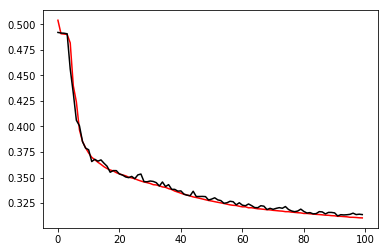

In [18]:
# visualizing losses and accuracy
train_loss = history.history['loss']
val_loss = history.history['val_loss']
xc = range(len(history.history['loss']))

plt.figure()
plt.plot(xc, train_loss, c="red")
plt.plot(xc, val_loss, c="black")

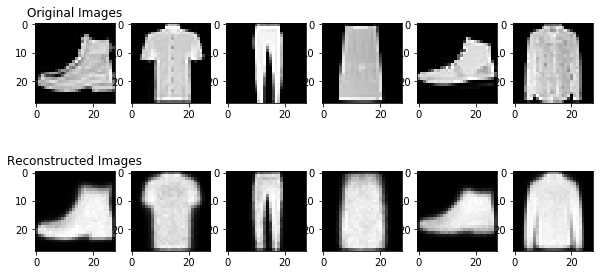

In [24]:
def plot_results(model, test_set_X, sample_size, dimensions):
    results = model.predict(test_set_X)
    n = sample_size
    plt.figure(figsize=(10, 5))
    rand_int = np.random.randint(1,101)
    for i in range(n):
        ax = plt.subplot(2, n, i + 1)
        plt.imshow(test_set_X[rand_int+i].reshape(dimensions))
        plt.gray()
        if i == 0:
            ax.set_title('Original Images')

        # plot reconstruction 
        ax = plt.subplot(2, n, i + 1 + n)
        plt.imshow(results[rand_int+i].reshape(dimensions))
        plt.gray()
        if i == 0:
            ax.set_title('Reconstructed Images')
    plt.show()
  
plot_results(model, x_test, 6, (28,28))

## Deep Convolutional Autoencoder

In [0]:
# Deep Convolution Autoencoder
cnn_input_layer = Input(shape=(28, 28, 1))

cnn_x = Conv2D(32, (3, 3), activation='relu', padding='same')(cnn_input_layer)
cnn_x = Conv2D(32, (3, 3), activation='relu', padding='same')(cnn_x)
cnn_x = MaxPooling2D((2, 2), padding='same')(cnn_x)
cnn_x = Conv2D(16, (3, 3), activation='relu', padding='same')(cnn_x)
cnn_x = Conv2D(16, (3, 3), activation='relu', padding='same')(cnn_x)
cnn_x = MaxPooling2D((2, 2), padding='same')(cnn_x)
cnn_x = Conv2D(8, (3, 3), activation='relu', padding='same')(cnn_x)
cnn_x = Conv2D(8, (3, 3), activation='relu', padding='same')(cnn_x)

cnn_encoded = MaxPooling2D((2, 2), padding='same')(cnn_x)

cnn_x = Conv2D(8, (3, 3), activation='relu', padding='same')(cnn_encoded)
cnn_x = UpSampling2D((2, 2))(cnn_x)
cnn_x = Conv2D(16, (3, 3), activation='relu', padding='same')(cnn_x)
cnn_x = UpSampling2D((2, 2))(cnn_x)
cnn_x = Conv2D(32, (3, 3), activation='relu')(cnn_x)
cnn_x = UpSampling2D((2, 2))(cnn_x)
cnn_decoded = Conv2D(1, (3, 3), activation='sigmoid', padding='same')(cnn_x)

cnn_model = keras.Model(cnn_input_layer, cnn_decoded)
cnn_model.compile(optimizer='adam', loss='binary_crossentropy')
history = cnn_model.fit(x_train, x_train,
                        epochs=100,
                        batch_size=512,
                        verbose=0,
                        shuffle=True,
                        validation_data=(x_test, x_test))

In [12]:
cnn_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 28, 28, 1)         0         
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 28, 28, 32)        320       
_________________________________________________________________
conv2d_12 (Conv2D)           (None, 28, 28, 32)        9248      
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_13 (Conv2D)           (None, 14, 14, 16)        4624      
_________________________________________________________________
conv2d_14 (Conv2D)           (None, 14, 14, 16)        2320      
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 7, 7, 16)          0         
__________

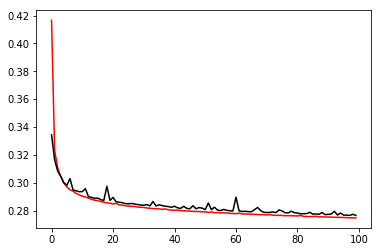

In [13]:
# visualizing losses and accuracy
train_loss = history.history['loss']
val_loss = history.history['val_loss']
xc = range(len(history.history['loss']))

plt.figure()
plt.plot(xc, train_loss, c="red")
plt.plot(xc, val_loss, c="black")

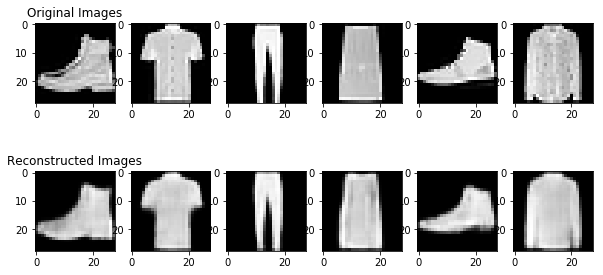

In [20]:
plot_results(cnn_model, x_test, 6, (28,28))

## Data Denoising using the Convolutional Autoencoder

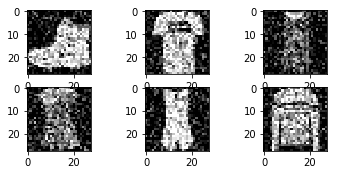

In [21]:
# add noise to the images
noise_factor = 0.25
x_train_noisy = x_train + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=x_train.shape) 
x_test_noisy = x_test + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=x_test.shape) 

x_train_noisy = np.clip(x_train_noisy, 0., 1.)
x_test_noisy = np.clip(x_test_noisy, 0., 1.)

for i in range(6):
	plt.subplot(330 + 1 + i)
	plt.imshow(x_train_noisy[i].reshape(28,28), cmap=plt.get_cmap('gray'))
plt.show()

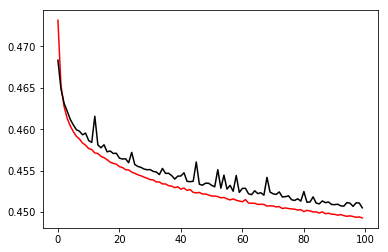

In [22]:
history = cnn_model.fit(x_train_noisy, x_train_noisy,
                        epochs=100,
                        batch_size=512,
                        verbose=0,
                        shuffle=True,
                        validation_data=(x_test_noisy, x_test_noisy))

# visualizing losses and accuracy
train_loss = history.history['loss']
val_loss = history.history['val_loss']
xc = range(len(history.history['loss']))

plt.figure()
plt.plot(xc, train_loss, c="red")
plt.plot(xc, val_loss, c="black")

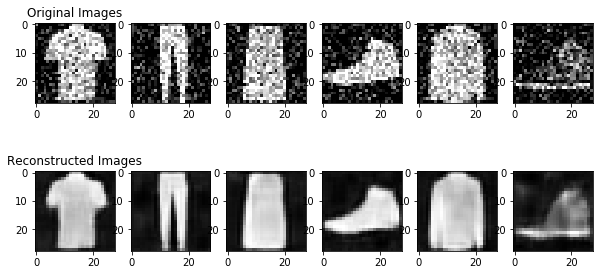

In [23]:
plot_results(cnn_model, x_test_noisy, 6, (28,28))